--- Starting Homework 6 ---
Using device: cuda (Tesla T4)

--- Setup Complete ---

--- Starting Task A: Image Similarity ---
Successfully loaded Bright_Tree.png and Dark_Tree.png.
Checking image sizes for similarity comparison...
Images resized for comparison: Gray=(1024, 1024), Color=(1024, 1024, 3)

Calculating Similarity Metrics (MSE, PSNR, SSIM)...
Mean Squared Error (MSE) - Grayscale: 1347.37
Mean Squared Error (MSE) - Color:     1356.77
Peak Signal-to-Noise Ratio (PSNR) - Grayscale: 16.84 dB
Peak Signal-to-Noise Ratio (PSNR) - Color:     16.81 dB
Structural Similarity Index (SSIM) - Grayscale: 0.7295
Structural Similarity Index (SSIM) - Color:     0.7225

--- Task A Finished ---

--- Starting Task B: Object Detection ---
Loading pre-trained Faster R-CNN model...
Model loaded successfully to cuda. Detecting 91 classes (COCO dataset).

Loading images for object detection...
Successfully loaded Kitchen image ((184, 274, 3)).
Successfully loaded StreetView image ((4500, 3000, 3)).
Su

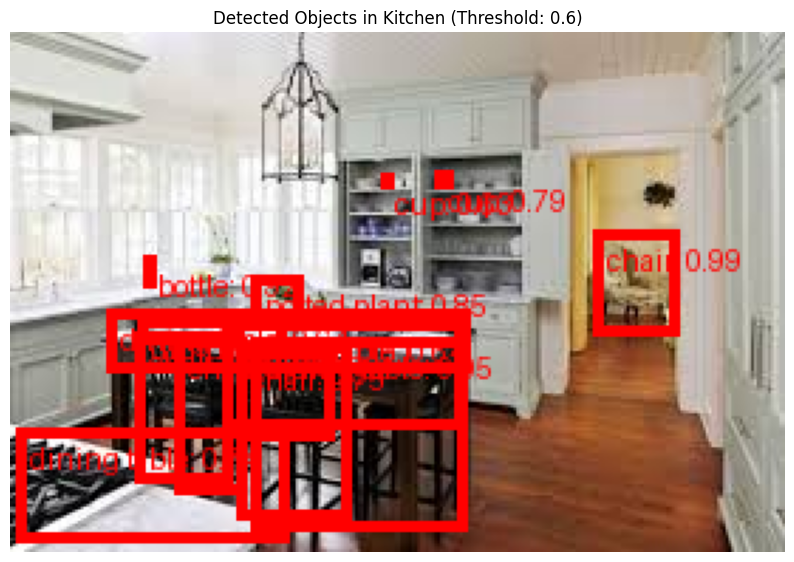


--- Detecting objects in: StreetView ---
Found 20 objects above threshold 0.6


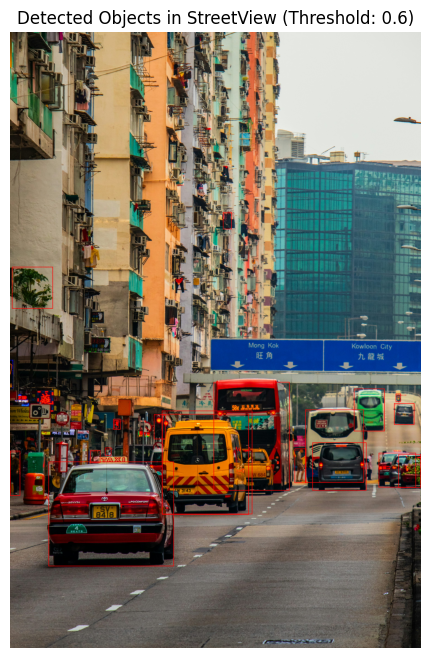


--- Detecting objects in: Zebra ---
Found 2 objects above threshold 0.6


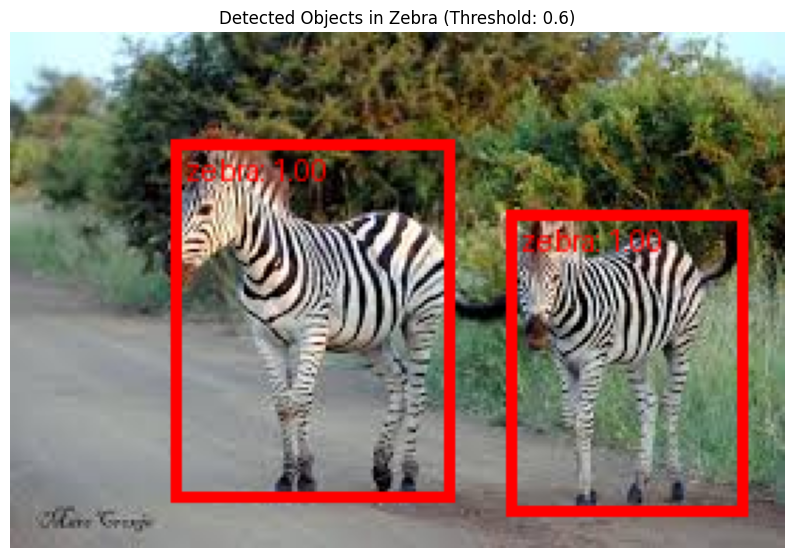


Object detection for 3 image(s) took 3.20 seconds.

--- Homework 6 Script Finished ---


In [4]:
# -------------------------------------------------------------------
# Homework 6: Image Similarity and Object Detection Code for Colab
# -------------------------------------------------------------------
# INSTRUCTIONS:
# 1. ENSURE GPU Runtime is active (Runtime -> Change runtime type -> GPU).
# 2. Upload the 5 required image files to Colab session storage (/content/):
#    - Bright_Tree.png
#    - Dark_Tree.png
#    - Kitchen.jpg
#    - StreetView.jpg
#    - Zebra.jpg
# 3. Run this cell.
# -------------------------------------------------------------------

print("--- Starting Homework 6 ---")

# Import necessary libraries
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes
import time
import os

# --- Helper Functions ---

def load_image(image_path, color_mode=cv2.IMREAD_COLOR):
    """Loads an image, converts to RGB if color, and handles alpha channel."""
    if not os.path.exists(image_path):
        print(f"ERROR: Image file not found at {image_path}. Please upload the file.")
        return None
    # Read image based on specified color mode
    if color_mode == cv2.IMREAD_COLOR:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    else:
         img = cv2.imread(image_path, color_mode)

    if img is None:
        print(f"ERROR: Could not load image from {image_path}. Check file integrity.")
        return None

    # Convert BGR (OpenCV default) to RGB for consistency with matplotlib/torchvision
    if color_mode == cv2.IMREAD_COLOR and len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Handle potential 4-channel images (like PNG with alpha) by converting to RGB
    if len(img.shape) == 3 and img.shape[2] == 4:
        print(f"Image {os.path.basename(image_path)} has alpha channel. Converting to RGB.")
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

    return img

def resize_image(img1, img2):
    """Resizes the second image to match the dimensions of the first image.
       Necessary for pixel-wise comparison metrics like MSE, PSNR, SSIM."""
    if img1 is None or img2 is None:
        print("Error: Cannot resize None images.")
        return None, None
    # If shapes already match, no resize needed
    if img1.shape == img2.shape:
        return img1, img2

    print(f"Resizing image 2 from {img2.shape[:2]} to match image 1 {img1.shape[:2]} for consistent comparison.")
    height, width = img1.shape[:2]
    # INTER_AREA is generally good for downscaling, reasonable for general purpose.
    img2_resized = cv2.resize(img2, (width, height), interpolation=cv2.INTER_AREA)
    return img1, img2_resized

def display_image(img, title="Image"):
    """Displays an image using matplotlib."""
    if img is None:
        print(f"Cannot display image: {title} (Image data is None)")
        return
    plt.figure(figsize=(10, 8))
    # Determine if the image is grayscale (2D) or color (3D) for correct display
    cmap = 'gray' if len(img.shape) == 2 else None
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Set Device to GPU ---
# Explicitly setting device to CUDA as GPU runtime is assumed to be enabled.
# This ensures tensor operations and model execution leverage the GPU.
device = torch.device("cuda")
print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")

print("\n--- Setup Complete ---")

# ===================================================================
# Task A: Image Similarity Computation
# ===================================================================
print("\n--- Starting Task A: Image Similarity ---")

# --- A1: Define Image Paths and Load Images ---
bright_tree_path = '/content/Bright_Tree.png'
dark_tree_path = '/content/Dark_Tree.png'

img_bright_color = load_image(bright_tree_path)
img_dark_color = load_image(dark_tree_path)

task_a_possible = True
if img_bright_color is None or img_dark_color is None:
    print("\nERROR: Cannot proceed with Task A - failed to load tree images.")
    task_a_possible = False
else:
    print(f"Successfully loaded {os.path.basename(bright_tree_path)} and {os.path.basename(dark_tree_path)}.")
    # Convert to grayscale for comparison, as some metrics are often applied to luminance channel
    img_bright_gray = cv2.cvtColor(img_bright_color, cv2.COLOR_RGB2GRAY)
    img_dark_gray = cv2.cvtColor(img_dark_color, cv2.COLOR_RGB2GRAY)

    print("Checking image sizes for similarity comparison...")
    # Resize images to ensure they have the exact same dimensions for metric calculation.
    # Using dimensions of the first loaded image as the target size.
    img_bright_gray, img_dark_gray = resize_image(img_bright_gray, img_dark_gray)
    img_bright_color, img_dark_color = resize_image(img_bright_color, img_dark_color)

    if img_bright_gray is None or img_bright_color is None:
         print("\nERROR: Resizing failed for Task A.")
         task_a_possible = False
    else:
        # Log the final size used for comparison
        print(f"Images resized for comparison: Gray={img_bright_gray.shape}, Color={img_bright_color.shape}")

# --- A2: Calculate Similarity Metrics ---
if task_a_possible:
    print("\nCalculating Similarity Metrics (MSE, PSNR, SSIM)...")
    # Calculate metrics for both grayscale and color versions for a comprehensive comparison.
    try:
        # --- Mean Squared Error (MSE): Lower is better (closer pixel values) ---
        mse_val_gray = mse(img_bright_gray, img_dark_gray)
        mse_val_color = mse(img_bright_color, img_dark_color)
        print(f"Mean Squared Error (MSE) - Grayscale: {mse_val_gray:.2f}")
        print(f"Mean Squared Error (MSE) - Color:     {mse_val_color:.2f}")

        # --- Peak Signal-to-Noise Ratio (PSNR): Higher is better (log scale of MSE) ---
        data_range = 255 # Assuming 8-bit image data [0-255]
        # Handle potential division by zero if images are identical (MSE=0)
        psnr_val_gray = psnr(img_bright_gray, img_dark_gray, data_range=data_range) if mse_val_gray > 0 else float('inf')
        psnr_val_color = psnr(img_bright_color, img_dark_color, data_range=data_range) if mse_val_color > 0 else float('inf')
        print(f"Peak Signal-to-Noise Ratio (PSNR) - Grayscale: {psnr_val_gray:.2f} dB")
        print(f"Peak Signal-to-Noise Ratio (PSNR) - Color:     {psnr_val_color:.2f} dB")

        # --- Structural Similarity Index (SSIM): Closer to 1 is better (perceptual similarity) ---
        # Determine appropriate window size for SSIM (must be odd, <= smaller dimension)
        min_dim_gray = min(img_bright_gray.shape)
        win_size_gray = min(7, min_dim_gray if min_dim_gray % 2 != 0 else min_dim_gray - 1)
        if win_size_gray < 3: win_size_gray = 3 # Ensure minimum size
        # Adjust if calculated win_size somehow exceeds minimum dimension after checks
        if win_size_gray > min_dim_gray: win_size_gray = min_dim_gray if min_dim_gray % 2 != 0 else min_dim_gray -1; win_size_gray = max(3, win_size_gray)

        min_dim_color = min(img_bright_color.shape[:2])
        win_size_color = min(7, min_dim_color if min_dim_color % 2 != 0 else min_dim_color - 1)
        if win_size_color < 3: win_size_color = 3
        # Adjust if calculated win_size somehow exceeds minimum dimension after checks
        if win_size_color > min_dim_color: win_size_color = min_dim_color if min_dim_color % 2 != 0 else min_dim_color - 1; win_size_color = max(3, win_size_color)

        ssim_val_gray = ssim(img_bright_gray, img_dark_gray, data_range=data_range, win_size=win_size_gray)
        # For color SSIM, specify multichannel=True and the channel axis (axis=2 for HWC format)
        ssim_val_color = ssim(img_bright_color, img_dark_color, data_range=data_range, multichannel=True, channel_axis=2, win_size=win_size_color)

        print(f"Structural Similarity Index (SSIM) - Grayscale: {ssim_val_gray:.4f}")
        print(f"Structural Similarity Index (SSIM) - Color:     {ssim_val_color:.4f}")

    except Exception as e:
        # Basic error catching for metric calculation issues
        print(f"\nERROR calculating similarity metrics: {e}")

print("\n--- Task A Finished ---")


# ===================================================================
# Task B: Object Detection using R-CNN
# ===================================================================
print("\n--- Starting Task B: Object Detection ---")

# --- B1: Load Object Detection Model ---
print("Loading pre-trained Faster R-CNN model...")
# Using Faster R-CNN with ResNet50 FPN backbone as required (part of the R-CNN family).
# Leveraging default weights pre-trained on COCO dataset for general object detection.
# This avoids training a model from scratch and uses knowledge from a large dataset.
model_loaded = False
try:
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    model.to(device) # Move model parameters to the GPU
    model.eval() # Set model to evaluation mode (disables dropout, etc.)

    preprocess = weights.transforms() # Get the correct preprocessing steps for this model
    class_names = weights.meta["categories"] # Get the list of class names the model can detect
    print(f"Model loaded successfully to {device}. Detecting {len(class_names)} classes (COCO dataset).")
    model_loaded = True
except Exception as e:
    print(f"\nERROR loading the detection model: {e}. Cannot proceed with Task B.")


# --- B2: Define Image Paths and Load Images for Detection ---
images_to_detect = {}
task_b_possible = False
if model_loaded:
    print("\nLoading images for object detection...")
    kitchen_path = '/content/Kitchen.jpg'
    streetview_path = '/content/StreetView.jpg'
    zebra_path = '/content/Zebra.jpg'

    image_paths_task_b = {"Kitchen": kitchen_path, "StreetView": streetview_path, "Zebra": zebra_path}
    all_b_images_loaded = True
    for name, path in image_paths_task_b.items():
        img = load_image(path)
        if img is not None:
            images_to_detect[name] = img
            print(f"Successfully loaded {name} image ({img.shape}).")
        else:
            print(f"Failed to load {name} image. Skipping detection for this image.")
            all_b_images_loaded = False

    # Check if we can proceed with Task B
    if images_to_detect and all_b_images_loaded:
         task_b_possible = True # All images loaded
    elif not images_to_detect:
         print("\nERROR: No images were successfully loaded for Task B.")
    else:
         # Some images failed, but at least one loaded
         print("\nWarning: Not all images for Task B were loaded successfully. Proceeding with loaded images.")
         if images_to_detect:
             task_b_possible = True # Proceed with the ones that loaded
         else:
             task_b_possible = False # Should not happen if check above works, but safeguard


# --- B3: Perform Object Detection and Visualize Results ---
if model_loaded and task_b_possible:
    print("\nPerforming object detection...")
    # Setting a detection threshold to filter out low-confidence predictions.
    # 0.6 is a common starting point, balancing precision and recall.
    detection_threshold = 0.6
    results = {} # Dictionary to optionally store detailed results
    start_time = time.time()

    # Process each image individually
    with torch.no_grad(): # Disable gradient calculation during inference for efficiency
        for name, img_rgb in images_to_detect.items():
            print(f"\n--- Detecting objects in: {name} ---")

            # Ensure image is uint8 HWC format before tensor conversion
            if img_rgb.dtype != np.uint8:
                if img_rgb.max() <= 1.0: img_rgb = (img_rgb * 255).astype(np.uint8)
                else: img_rgb = img_rgb.astype(np.uint8)

            # Convert image to tensor (C, H, W), normalize, apply transforms, send to device
            img_tensor_chw_float = torch.from_numpy(img_rgb.transpose(2, 0, 1)) / 255.0
            batch = [preprocess(img_tensor_chw_float).to(device)]

            # Get model predictions
            predictions = model(batch)[0] # Get predictions for the first (only) image in batch

            # Move results back to CPU for filtering and visualization
            boxes = predictions["boxes"].cpu()
            labels = predictions["labels"].cpu()
            scores = predictions["scores"].cpu()

            # Filter detections based on the confidence threshold
            keep = scores > detection_threshold
            boxes_filtered = boxes[keep]
            labels_filtered = labels[keep]
            scores_filtered = scores[keep]

            print(f"Found {len(boxes_filtered)} objects above threshold {detection_threshold}")

            # Prepare labels with scores for drawing onto the image
            detected_labels_with_scores = [
                f"{class_names[label.item()]}: {score:.2f}" # Format: ClassName: 0.xx
                for label, score in zip(labels_filtered, scores_filtered)
            ]
            # Store plain labels if needed later
            detected_plain_labels = [class_names[label.item()] for label in labels_filtered]

            # Draw bounding boxes on the original image (needs uint8 tensor C, H, W)
            img_uint8_tensor_chw = torch.from_numpy(img_rgb.transpose(2, 0, 1))
            output_image_tensor = draw_bounding_boxes(
                img_uint8_tensor_chw, boxes_filtered, # Use the filtered boxes
                labels=detected_labels_with_scores,
                colors="red", width=4, font_size=20 # Visual parameters for boxes/text
            )
            # Convert back to HWC format for display with matplotlib
            output_image_np = output_image_tensor.permute(1, 2, 0).numpy()

            # Store results (optional, useful for report)
            results[name] = {
                'image_with_boxes': output_image_np,
                'boxes': boxes_filtered.numpy(),
                'labels': detected_plain_labels,
                'scores': scores_filtered.numpy()
            }
            # Display the image with detected objects
            display_image(output_image_np, f"Detected Objects in {name} (Threshold: {detection_threshold})")

    end_time = time.time()
    print(f"\nObject detection for {len(images_to_detect)} image(s) took {end_time - start_time:.2f} seconds.")

# Handle cases where Task B couldn't run
elif not model_loaded:
    print("\nSkipping Task B object detection because the model failed to load.")
elif not task_b_possible:
    print("\nSkipping Task B object detection because image loading failed or was incomplete.")


print("\n--- Homework 6 Script Finished ---")